В данном блокноте я решил использовать easyoct для считывания слов с российских паспортов. Загрузим все необходимые библиотеки и данные.

In [373]:
from PIL import Image
from pathlib import Path
import easyocr 
import cv2
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
reader = easyocr.Reader(['ru'], gpu= False)

Using CPU. Note: This module is much faster with a GPU.


Чтобы распознать ФИО со считанных слов будем использовать "natasha"

In [374]:
from natasha import (Segmenter,MorphVocab, PER, NewsSyntaxParser, NewsMorphTagger, NamesExtractor, NewsNERTagger, NewsEmbedding, Doc)
 
segmenter = Segmenter()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
segmenter = Segmenter()
morph_vocab = MorphVocab()
ner_tagger = NewsNERTagger(emb)
names_extractor = NamesExtractor(morph_vocab)

Считываем символы с фотографий

In [401]:
text1, images= [], list(Path(r'C:\Users\xiaom\Desktop\git\all_things\Russian passport OCR\DataForOCR').rglob('**/*'))
for im in images:
    text1.append(reader.readtext('{0}'.format(im), detail = 0)) 

Библиотека easyocr, как видно из считанного текста, работает с паспортами лучше, чем tesseract. 

С с и и с к ; я 4 Е ₽ ПАСПОРТНО-визовым ОтДЕЛЕНИЕМ овд ПРЕСНЕНСКОГО РАЙОНА УВД ЦАО ГОРОДА МОСКВЫ 09.11.2016 аарачагыы 772-112 & ~/ ТРАМП ДОНАЛЬД Джон Муж 14 . 06 . 1946 ГОР КУИНС ШТАТ НЬЮ-ЙОРК 8 США


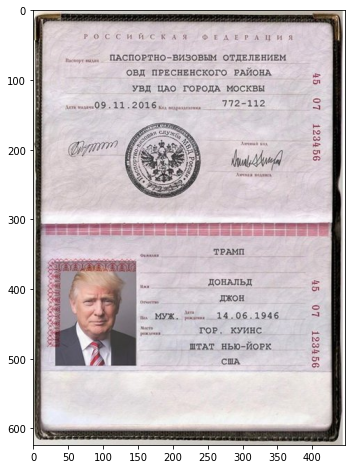

In [402]:
print(' '.join(text1[0]))
fig, ax= plt.subplots(figsize= (10, 8))
ax.imshow(Image.open(images[0]))
plt.show()

Natasha совсем не хочет считывать ФИО, возможно это связано с их сильно случайным форматом.

Попробуем обработать полученный текст. Первым делом уберем ненужные символы, которые ФИО не может содержать. Неплохой идеей будет иcпользовать лемматизацию, чтобы привести их к начальной форме, но это может сильно исказить ФИО. После этого, также, в паспортах пресутствуют одиноковые характерные документам слова: "фамилия", "выдан" и тд. Я их тоже постораюсь убрать, используя в качестве критерия относительную долю схожих букв лемматизированных слов. 

In [403]:
def lemmatize(word):
    doc = Doc(word)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    doc.parse_syntax(syntax_parser)
    doc.tag_ner(ner_tagger)
    for token in doc.tokens:
        token.lemmatize(morph_vocab)

    return [_.lemma for _ in doc.tokens]

In [404]:
alphabet= 'АаБбВвГгДдЕеЁёЖжЗзИиЙйКкЛлМмНнОоПпРрСсТтУуФфХхЦцЧчШшЩщЪъЫыЬьЭэЮюЯя'
vocabulary= ['фамилия','имя', 'отчество','россия','федерация','паспорт','выдать','дата','муж','жен','район','гор','рождения','уфмс','овд','отдел','область','страничка','место','рождение','пол','возраст','город','страна','штат']
vocabulary= np.squeeze([lemmatize(word) for word in vocabulary])

def alphabet_processing(text): # убираем ненужные символы
    proccesed_text= []
    for sentence in text:
        processed_sentence= []
        for word in sentence:
            if set(word) & set(alphabet) ==  set(word) and len(word)>2:
                processed_sentence.append(word)
        proccesed_text.append(processed_sentence)
    return proccesed_text


def letter_processing(text, max_distance= 0.5):
    proccesed_text= []
    for sentence in text:
        proccesed_sentence= []
        for word in sentence: # проходим по каждому слову задектированного предложения
            lemmatized_word= lemmatize(word)[0]
            flag= True
            for voc in vocabulary:
                if len(voc)==len(lemmatized_word) and np.sum(np.array(list(voc))==np.array(list(lemmatized_word)))/len(voc)>max_distance:
                    flag= False
            if flag:
                proccesed_sentence.append(word.lower()) 
        proccesed_text.append(proccesed_sentence)
    return proccesed_text

In [405]:
proccesed_text= alphabet_processing(text1)
proccesed_text= letter_processing(proccesed_text)

Заметно, что после обработки данные стали гораздо чище, стало легче определить ФИО. Я также пробовал выделить именя с помощью библиотеки Natasha, но она делает это довольно плохо, вероятно из-за случайности регистра букв. Мне не пришла идея лучше, чем использовать большую базу ФИО, по которой можно проверить схожеть считанных слов на наличие ФИО. Но при этом этот способ не лешен минусов, в базе могут пресутсвовать далеко не все ФИО, по-этому, я буду брать только самые уверенные слова. Еще один вопрос стоит с том, что брать в качестве ответа, можно брать слова ФИО из базы данных или поверить, что easyocr хорошо считывает информацию и брать ответ из нее. (конечно не хорошо смотреть на тестовые данные, так под них происходит подбор гиперпараметров, но я поверю, что easyocr хоро считает данные и для других паспортов) 

In [406]:
proccesed_text[:3]

[['пресненского', 'аарачагыы', 'трамп', 'дональд', 'джон', 'куинс', 'сша'],
 ['халабудина', 'юлия', 'алексеевна', 'мончегорск'],
 ['яиа',
  'краснознаменск',
  'шапошникова',
  'виктория',
  'николаевна',
  'краснознаменск']]

In [407]:
DIR_names, DIR_surnames, DIR_secondnames= Path(r'C:\Users\xiaom\Desktop\git\all_things\Russian passport OCR\With OCR libraries\additional data\russian_names.txt'), Path(r'C:\Users\xiaom\Desktop\git\all_things\Russian passport OCR\With OCR libraries\additional data\russian_surnames.txt'), Path(r'C:\Users\xiaom\Desktop\git\all_things\Russian passport OCR\With OCR libraries\additional data\russian_seconnames.txt')
DIR_cities= Path(r'C:\Users\xiaom\Desktop\git\all_things\Russian passport OCR\With OCR libraries\additional data\cities.txt')
with open(DIR_names, 'r', encoding="utf8") as f:
    names= [line.strip().lower() for line in f]
with open(DIR_surnames, 'r', encoding="utf8") as f:
    surnames= [line.strip().lower() for line in f]
with open(DIR_secondnames, 'r', encoding="utf8") as f:
    second_names= [line.strip().lower() for line in f]
with open(DIR_cities, 'r', encoding="utf8") as f:
    cities= [line.strip().lower() for line in f]
print('Количество фамилий-', len(surnames), 'Количество имен-', len(names), 'Количество отчеств-', len(second_names))
names= names+surnames+second_names
print('Всего-' ,len(names))

Количество фамилий- 251337 Количество имен- 1674 Количество отчеств- 1238
Всего- 254249


In [408]:
' '.join(np.random.choice(names,5))

'гилярова панжинская брейгин куцишина зельманзон'

In [409]:
def name_search(text):
    proccesed_text= []
    for sentence in text:
        proccesed_sentence= []
        for idx, word in enumerate(sentence):  # проходим по всем словам в детектированном предложении
            similarity= 0
            for name in names:     # проходим по всем фамилияем 
                if len(word)==len(name):
                    sim= np.sum(np.array(list(name))==np.array(list(word)))/(len(word)+2)
                    similarity= max(similarity, sim)
            proccesed_sentence.append((similarity, idx, word))
        proccesed_text.append([sentence[idex] for idex in sorted([item[1] for item in sorted(proccesed_sentence, reverse= True)[:3]])])
    return proccesed_text

In [410]:
proccesed_text[5]

['отделение',
 'шмин',
 'псковской',
 'пыталовском',
 'макаров',
 'роман',
 'юрьевич',
 'мат',
 'дер',
 'бороусы',
 'пыталовского',
 'рна',
 'псковской',
 'обл']

In [411]:
proccesed_text[-2]

['пермскому',
 'краю',
 'глазове',
 'кузеванов',
 'александр',
 'игоревич',
 'глазов']

In [412]:
proccesed_text2= name_search(proccesed_text)

Получилось по некоторым меркам неплохо, 5 ФИО считаны полность и в правильном порядке. У 4х из оставшихся правильно предсказано 2 слова из ФИО, в некоторых случаях порядок нарушется. 


При этом в большенстве ошибок за ФИО принимается название города, которое указано в строке места выдачи паспорта. Можно было бы убрать верхнюю часть паспорта или убрать города совсем, но это сильно ограничивает обность данных: паспорт на фотографии может быть смещен, а фамилия человека содержать название города. Можно понижать коэффициент схожести при встречанни слова, которое схоже с городом.

In [413]:
for item  in proccesed_text2:
    print(' '.join(item))

трамп дональд джон
халабудина юлия алексеевна
шапошникова виктория николаевна
даймонд дмитрий алексеевич
сокалот андреи андреенич
макаров юрьевич псковской
петровиц руд красноярстото
евгений александрович архангельск
кузеванов александр глазов
свердловской кмакаева анатольевна


In [418]:
with open('result.txt', 'w', encoding= 'utf8') as file:
    for item  in proccesed_text2:
        name= item[1][0].upper()+item[1][1:]
        last_name= item[0][0].upper()+item[0][1:]
        second_name= item[2][0].upper()+item[2][1:] 
        file.write(' Фамилия:'+last_name+'; Имя:'+name+'; Отчество:'+second_name+'\n')
        


In [ ]:
''.upper

Посмотрим результаты, если мы уберем слова, похожие на города. 

In [389]:
proccesed_text= alphabet_processing(text1)
proccesed_text2= letter_processing(proccesed_text, max_distance= 0.5)

In [390]:
vocabulary= np.append(np.concatenate([lemmatize(word) for word in cities]), vocabulary) 

In [391]:
proccesed_text= letter_processing(proccesed_text2, max_distance=0.7)
proccesed_text2= name_search(proccesed_text)

Видим, что лучше не стало, так как, некоторые ФИО близки с названиями городов.

In [392]:
for item  in proccesed_text2:
    print(' '.join(item))

трамп дональд джон
халабудина юлия
яиа шапошникова виктория
самарской даймонд дмитрий
сокалот андреи андреенич
шмин роман юрьевич
ровд петровиц красноярстото
дел евгений отчетво
кузеванов александр игоревич
лтделом кмакаева анатольевна


#### Фильтры

Попробую использовать фильтры, которые делают текст на картинки более ярковыраженным. Также переведем картинку в черно-белый формат и посмотрим на результат.

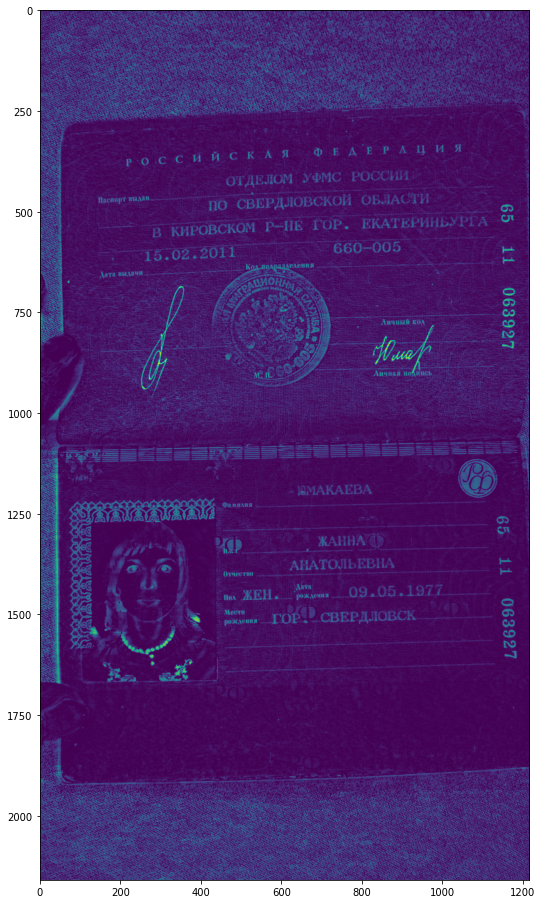

In [393]:
blackhat_images= []
for image in images:
    image = cv2.imread(r'{0}'.format(image))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    (H, W) = gray.shape
    rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 7))
    sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 21))
    gray = cv2.GaussianBlur(gray, (3, 3), 0)
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKernel)
    blackhat_images.append(blackhat)

fig, ax= plt.subplots(figsize= (16, 16))
ax.imshow(blackhat) # cv.inshow не работает в коллабе
plt.show()

In [394]:
text2= []
for im in blackhat_images:
    text2.append(reader.readtext(im, detail = 0)) 

In [395]:
proccesed_text_black= alphabet_processing(text2)
' '.join(proccesed_text_black[0])

'ПАСПОРтНО овд ТРАГП доннлыд штон ГОР тушнс син'

Как видим, это работает только хуже. Вероятно, это связано с тем, что easyocr использует нейросетевой подход и нейросети лучше работают с обычными, необработанными изображениями.

In [396]:
proccesed_text_black

[['ПАСПОРтНО', 'овд', 'ТРАГП', 'доннлыд', 'штон', 'ГОР', 'тушнс', 'син'],
 ['ХАЛАБУДИНА', 'ЮЛИЯ', 'АЛЕКСЕЕВНА', 'ШОНЧЕГОРСК'],
 ['ГОР',
  'КРАСНОЭНАРЕНСК',
  'шАпошниковА',
  'ВИКТОРИЯ',
  'НИКОЛАЕВНА',
  'АЕН',
  'ГОР',
  'КРАСНОЗНАМЕНСК',
  'страничка',
  'Паспорт',
  'кСтоимость'],
 ['ОТДЕЛОМ',
  'УФМС',
  'РоССИИ',
  'САМАРСКОЙ',
  'ОБЛАСТИ',
  'ЦЕНТРАЛЬНОМ',
  'РАЙОНЕ',
  'ГОРОДА',
  'тольятти',
  'Датвш',
  'Амнынкод',
  'ДАЙмОНД',
  'ДМИТРИЙ',
  'АЛЕКСЕЕВИЧ',
  'Шол',
  'МУЖ',
  'Даддения',
  'ГОР',
  'САМАРА',
  'служба',
  'визовал'],
 ['ШоснмЛЕнънтиннашов', 'МбШШШ'],
 ['ОТДЕЛЕНИЕ',
  'УТмС',
  'России',
  'пеконскои',
  'ОБЛАСТИ',
  'шытАовском',
  'РАИОНЕ',
  'МКРОВ',
  'РОМАН',
  'ФРЬЕВИЧ',
  'ДЕР',
  'БОГусн',
  'ШЫТАЛОВСКОГО',
  'пековскои'],
 ['РоП', 'нитинэ', 'ГоРнбсаны', 'БАСЛЕНСЮ', 'ПЕЕРОВ', 'СЕАРИНСков'],
 ['ДЕЛ',
  'Шисрви',
  'ОКТЯБРЬСКОГО',
  'ОКРУГА',
  'ГОРОДА',
  'АРХАНГЕЛЬСКА',
  'ИМЯРЕК',
  'ЕВГЕНИЙ',
  'АЛЕКСАНДРОВИЧ',
  'АРХАНГЕЛЬСК',
  'служч',
  'ваЯ',
  